In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [2]:
plt.rcParams["figure.dpi"] = 150

## データの生成
まず$x$の値を$(0,5)$から30個（num_data）ランダムに生成する。式では
$$
x \sim \mathcal{U}(0,5)
$$
などと表す（$\mathcal{U}(a,b)$は$a$, $b$の間の一様分布）。$x$の値は動かさない。

In [3]:
num_data = 30

In [4]:
np.random.seed(123)
x = np.random.rand(num_data) * 5

In [5]:
x

array([3.48234593, 1.43069667, 1.13425727, 2.75657385, 3.59734485,
       2.1155323 , 4.90382099, 3.42414869, 2.40465951, 1.96058759,
       1.71589008, 3.64524854, 2.19286122, 0.29838948, 1.99022128,
       3.68997703, 0.91245865, 0.87725878, 2.65775687, 2.65913794,
       3.17200479, 4.24715897, 3.62227662, 3.05511755, 3.61221691,
       1.61479457, 1.80894328, 1.14131615, 1.46857023, 3.15488062])

次に、パラメータ$y$と$x$の関係が
$$ y= ax+b $$
であると仮定して、$y$の真の値$y_\mathrm{true}$を30個生成する。ここでは$a=1.2$, $b=-0.5$とする。

In [6]:
def true_model(x, a=1.2, b=-0.5):
    model = a * x + b 
    return model

In [7]:
y_true = true_model(x)

両者の関係をプロットすると（当然）直線になっている。

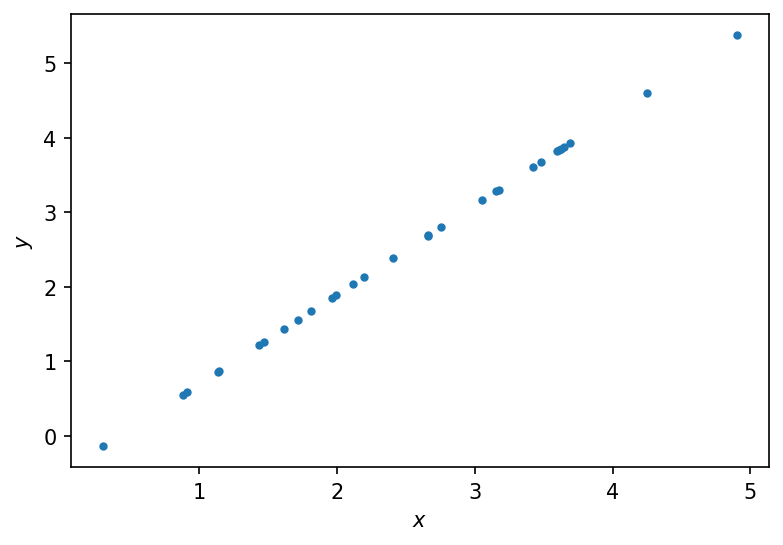

In [8]:
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.plot(x, y_true, '.');

次に$y$を測定して測定値$y_\mathrm{obs}$を得る状況を考えよう。$y_\mathrm{obs}$と$y_\mathrm{true}$は測定誤差のため異なる値をとる。ここでは、測定誤差$e$が平均$0$, 標準偏差$\sigma_\mathrm{true}=0.3$の正規分布に従うとしよう。式で表すと
$$ y_\mathrm{obs} = y_\mathrm{true} + e, \quad e \sim \mathcal{N}(0,\sigma_\mathrm{true}) $$
などとなる。$\mathcal{N}(a,b)$は平均$a$, 標準偏差$b$の正規分布を表す。

In [9]:
np.random.seed(124)
sigma_true = 0.3
noise = np.random.randn(num_data) * sigma_true
y_obs = y_true + noise

さらにここでは、$y_\mathrm{obs}$を測定する際に、何らかの方法で測定誤差の標準偏差$\sigma_\mathrm{true}$が正しく推定できているとしよう（一般にはそうとは限らない）。これが$y_\mathrm{obs}$の各測定点の"エラーバー" $y_\mathrm{err}$である。

In [10]:
y_err = np.ones(num_data) * sigma_true

生成したデータをプロットしてみる。測定誤差のため本来の線形関係から外れてばらついている。

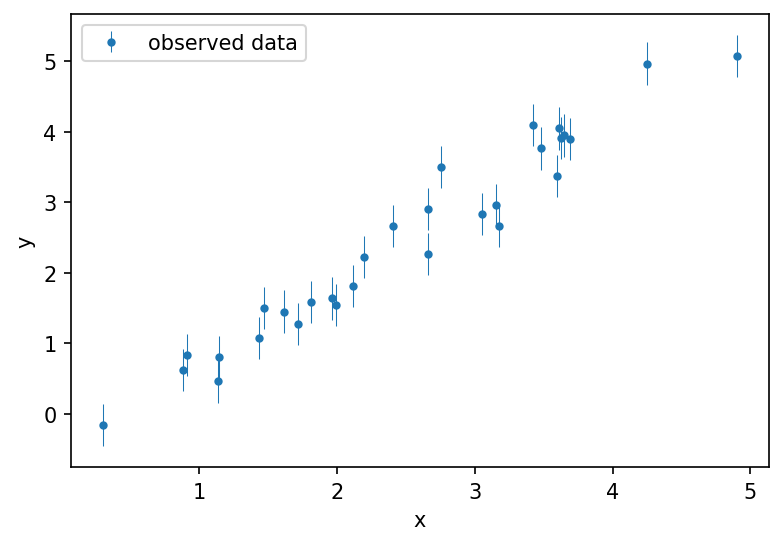

In [11]:
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(x, y_obs, fmt='o', yerr=y_err, lw=0.5, markersize=3, label='observed data')
plt.legend();

## モデルパラメータ推定

まとめると、予め決められた$x$の値に対して、測定値$y_\mathrm{obs}$とその測定精度についての情報$y_\mathrm{err}$が与えられている。ここでは、$y$の真の値$y_\mathrm{true}$が
$$ y_\mathrm{true} = a x + b $$
で与えられると仮定して（つまり"正しい"モデルを知っているという設定で）、$y_\mathrm{obs}$, $y_\mathrm{err}$から$(a,b)$を推定しよう。

一口に"推定"と言っても様々な方針があり得るが、ここではデータ$y_\mathrm{obs}$に条件づけられたパラメータ$(a,b)$の事後確率分布に基づくベイズ推定を行う。より具体的には、JAX, NumPyroを用いたマルコフ連鎖モンテカルロ法（MCMC）により、事後確率分布
$$
p(a,b|y_\mathrm{obs}) = {p(y_\mathrm{obs}|a, b)\,p(a,b) \over p(y_\mathrm{obs})}
$$
に従う$(a,b)$のサンプルを生成する。JAXやNumPyroについては　http://secondearths.sakura.ne.jp/jax/playjax.pdf　も参照。

必要なのは、既知の$x$, 測定値$y_\mathrm{obs}$, 測定誤差$y_\mathrm{err}$の確率的な関係である。再度書くと
$$
 y_\mathrm{obs} = ax + b + e, \quad e \sim \mathcal{N}(0,y_\mathrm{err})
$$
である。この関係は以下のような関数で記述される。

In [12]:
def linear_model(x, yobs, yerr):
    a = numpyro.sample("a", dist.Uniform(-5, 5))
    b = numpyro.sample("b", dist.Uniform(-5, 5))
    model = numpyro.deterministic("model", a*x+b)
    numpyro.sample("obs", dist.Normal(model, yerr), obs=yobs)

ここで、
$$ a \sim \mathcal{U}(-5, 5), \quad b \sim \mathcal{U}(-5,5) $$
としている。これらはパラメータ$a$, $b$の事前確率分布と呼ばれる。

次にMCMCによりパラメータ$a$,$b$の事後確率分布
$$
p(a,b|y_\mathrm{obs}) = p(y_\mathrm{obs}|a, b)\,p(a,b)
$$
に従うサンプルを生成する。ここではNumPyroに実装されているNo-U-Turn Sampler (NUTS)を使う。

In [13]:
kernel = numpyro.infer.NUTS(linear_model)

In [14]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=1000)

In [15]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y_obs, y_err)

sample: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 693.90it/s, 15 steps of size 2.84e-01. acc. prob=0.95]


In [16]:
# 事後分布に従うサンプル
samples = mcmc.get_samples()

$a$, $b$の2次元ヒストグラムを作って真の値（青の実線）と比べてみる。

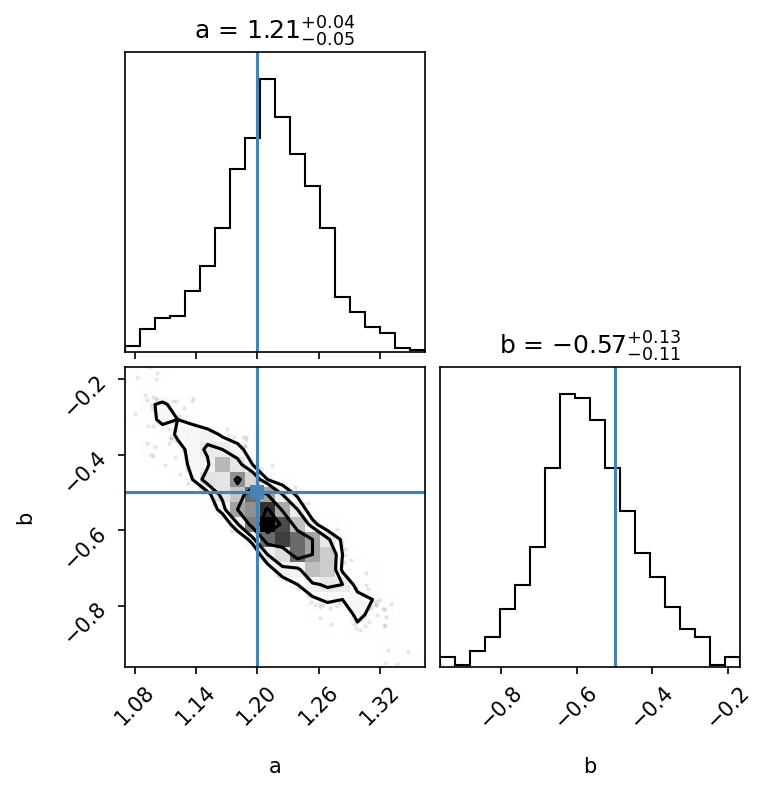

In [17]:
import corner
fig = corner.corner(np.array([samples['a'], samples['b']]).T, labels=['a', 'b'], show_titles=True,
                   truths=[1.2,-0.5])

生成したパラメータ$(a,b)$のサンプルからランダムに20個取り出し、データとともにプロットする。

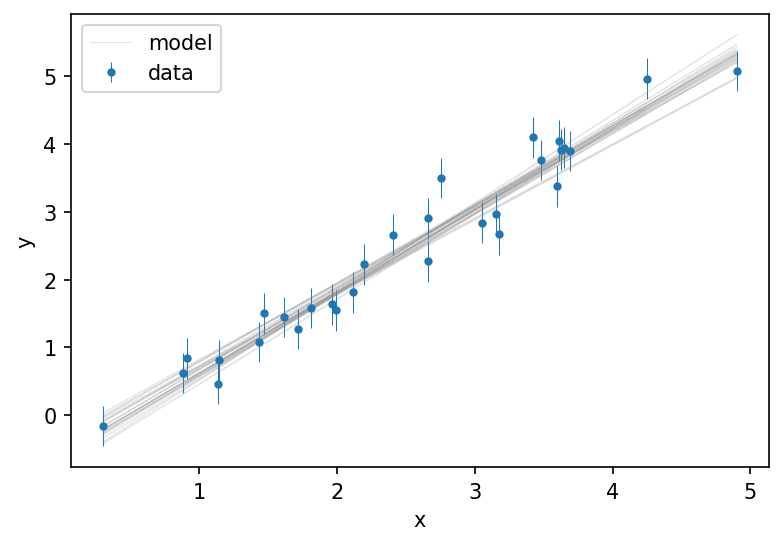

In [19]:
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(x, y_obs, fmt='o', yerr=y_err, lw=0.5, markersize=3, label='data')
for i,idx in enumerate(np.random.randint(0, 500, 20)):
    a_sample, b_sample = samples['a'][idx], samples['b'][idx]
    label = "model" if i==0 else ""
    plt.plot(x, a_sample * x + b_sample, color='gray', lw=0.5, alpha=0.2, label=label)
plt.legend();

要約統計量（summary statistic）の表示

In [20]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.21      0.05      1.21      1.13      1.28    326.16      1.00
         b     -0.57      0.13     -0.57     -0.77     -0.34    298.38      1.00

Number of divergences: 0


trace plotの表示

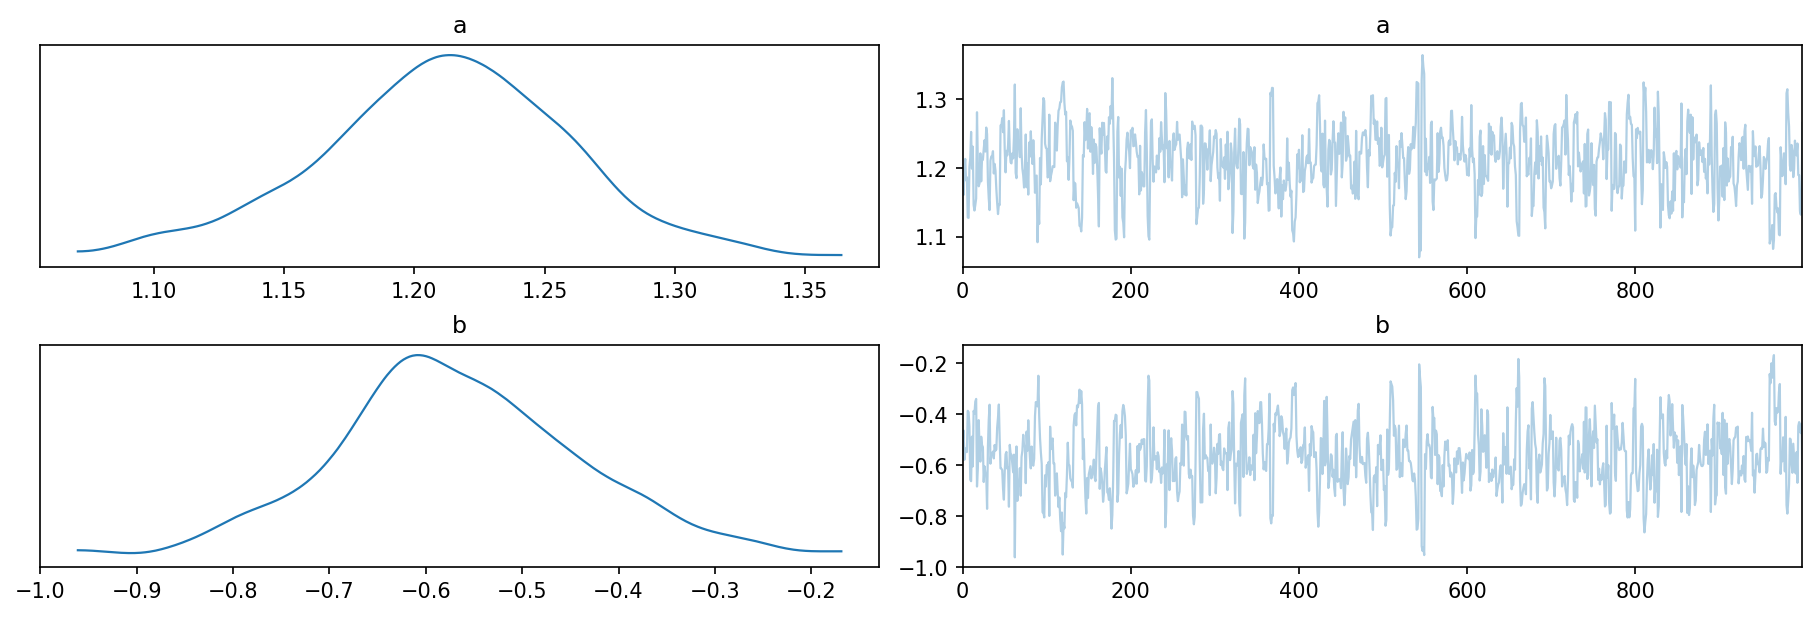

In [22]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=['a', 'b'])